<a href="https://colab.research.google.com/github/Lilhxr/leaf_detect/blob/main/Explore_Lossfunctions_Robust_with_Noisy_Dataset_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! kaggle competitions download -c cassava-leaf-disease-classification

100% 5.75G/5.76G [00:49<00:00, 113MB/s]
100% 5.76G/5.76G [00:49<00:00, 125MB/s]


**Imports**

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # For plotting

from keras import backend as K # Losses
import tensorflow as tf # Tensorflow

**Standard Loss**

for Target 1

In [ ]:
K.binary_crossentropy

<function keras.backend.binary_crossentropy>

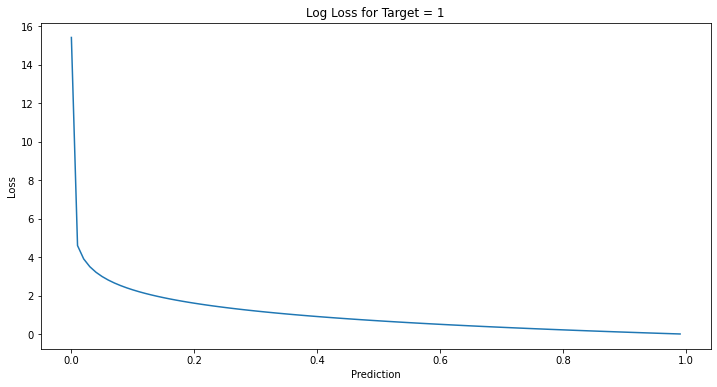

In [ ]:
inputs = [x/100 for x in range(0, 100, 1)]
outputs = []

for i in inputs:
    outputs.append(K.binary_crossentropy(tf.convert_to_tensor([1.0]), tf.convert_to_tensor([i])).numpy()[0])
    
plt.figure(figsize=(12,6))
plt.plot(inputs, outputs)
plt.title("Log Loss for Target = 1")
plt.xlabel("Prediction")
plt.ylabel("Loss")
plt.show()

Symmetric Cross Entropy:

Inspired by the symmetric KL-divergence, the paper proposes the approach of Symmetric cross entropy Learning (SL), boosting CE symmetrically with a noise robust counterpart Reverse Cross Entropy (RCE). The proposed SL simultaneously addresses both the under learning and overfitting problem of CE in the presence of noisy labels

https://arxiv.org/pdf/1908.06112.pdf


In [ ]:
def symmetric_cross_entropy(y_true, y_pred, alpha, beta):
    """
    2019 - Symmetric Cross Entropy for Robust Learning with Noisy Labels - https://arxiv.org/pdf/1908.06112.pdf
    """
    y_true_1 = y_true
    y_pred_1 = y_pred

    y_true_2 = y_true
    y_pred_2 = y_pred

    y_pred_1 = tf.clip_by_value(y_pred_1, 1e-7, 1.0)
    y_true_2 = tf.clip_by_value(y_true_2, 1e-4, 1.0)

    return alpha*tf.reduce_mean(-tf.reduce_sum(y_true_1 * tf.math.log(y_pred_1), axis = -1)) + beta*tf.reduce_mean(-tf.reduce_sum(y_pred_2 * tf.math.log(y_true_2), axis = -1))

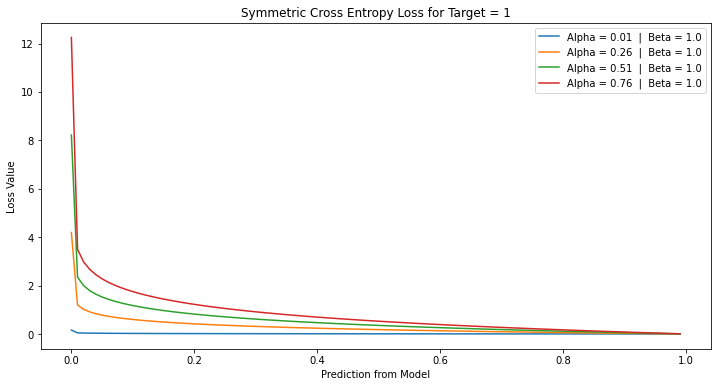

In [ ]:
inputs = [x/100 for x in range(0, 100, 1)]

plt.figure(figsize=(12,6))

for a in [alpha/100 for alpha in range(1, 100, 25)]:
    outputs = []
    for i in inputs:
        outputs.append(symmetric_cross_entropy(tf.convert_to_tensor([1.0]), tf.convert_to_tensor([i]), a, 1.0).numpy())
    
    plt.plot(inputs, outputs, label="Alpha = " + str(a) + "  |  Beta = 1.0")
    plt.title("Symmetric Cross Entropy Loss for Target = 1")
    plt.xlabel("Prediction from Model")
    plt.ylabel("Loss Value")

plt.legend()
plt.legend()
plt.show()

**Generalized Cross Entropy Loss**
It is proposed as a theoretically grounded noise-robust loss function that can be seen as a generalization of MAE and CCE.

https://arxiv.org/pdf/1805.07836.pdf

In [ ]:
def generalized_cross_entropy(y_true, y_pred, q):
    """
    2018 - Generalized Cross Entropy Loss for Training Deep Neural Networks with Noisy Labels - https://arxiv.org/pdf/1805.07836.pdf
    """
    intermed_ = tf.pow(tf.reduce_sum(y_true * y_pred, axis=-1), q)
    t_loss = (1 - intermed_) / q
    return tf.reduce_mean(t_loss)

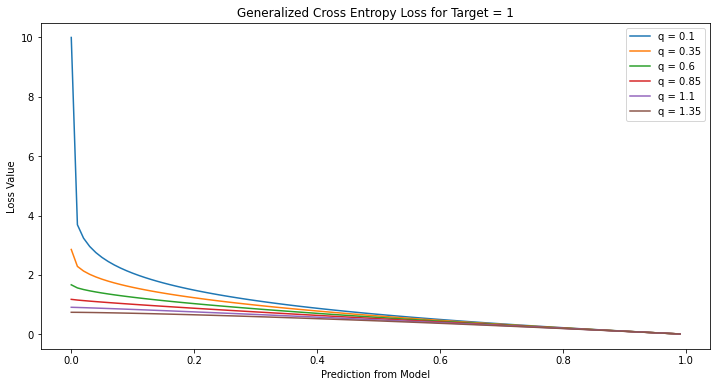

In [ ]:
inputs = [x/100 for x in range(0, 100, 1)]

plt.figure(figsize=(12,6))

for q in [limit/100 for limit in range(10, 150, 25)]:
    outputs = []
    for i in inputs:
        outputs.append(generalized_cross_entropy(tf.convert_to_tensor([1.0]), tf.convert_to_tensor([i]), q).numpy())
    
    plt.plot(inputs, outputs, label="q = " + str(q))
    plt.title("Generalized Cross Entropy Loss for Target = 1")
    plt.xlabel("Prediction from Model")
    plt.ylabel("Loss Value")

plt.legend()
plt.legend()
plt.show()

**Label Smoothing Regularization**

Label Smoothing Regularizing is done on neural networks by penalizing low entropy output distributions. It prevents overfitting on noisy labels by smoothing labels.

https://arxiv.org/pdf/1701.06548.pdf

In [ ]:
def lsr(y_true, y_pred, epsilon):
   
    y_smoothed_true = y_true * (1 - epsilon - epsilon / 10.0)
    y_smoothed_true = y_smoothed_true + epsilon / 10.0

    y_pred_1 = tf.clip_by_value(y_pred, 1e-7, 1.0)

    return tf.reduce_mean(-tf.reduce_sum(y_smoothed_true * tf.math.log(y_pred_1), axis=-1))  

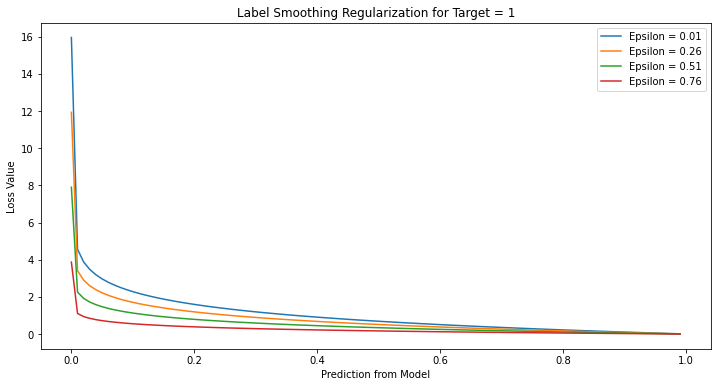

In [ ]:
inputs = [x/100 for x in range(0, 100, 1)]

plt.figure(figsize=(12,6))

for e in [eps/100 for eps in range(1, 100, 25)]:
    outputs = []
    for i in inputs:
        outputs.append(lsr(tf.convert_to_tensor(1.0), tf.convert_to_tensor([i]), e).numpy())
    
    plt.plot(inputs, outputs, label="Epsilon = " + str(e))
    plt.title("Label Smoothing Regularization for Target = 1")
    plt.xlabel("Prediction from Model")
    plt.ylabel("Loss Value")

plt.legend()
plt.legend()
plt.show()

**Joint Optimization Loss**

This paper proposes a joint optimization framework of learning DNN parameters and estimating true labels. The framework can correct labels during training by alternating update of network parameters and labels

https://arxiv.org/pdf/1803.11364.pdf

THIS PAPER HAS A SECOND COMPONENT OF UPDATING LABELS REFER TO THE PAPER OR GITHUB HERE

https://github.com/DaikiTanaka-UT/JointOptimization

In [ ]:
def joint_optimization_loss(y_true, y_pred):
    """
    2018 - Joint optimization framework for learning with noisy labels - https://arxiv.org/pdf/1803.11364.pdf
    """
    y_pred_avg = K.mean(y_pred, axis=0)
    p = np.ones(10, dtype=np.float32) / 10.
    l_p = - K.sum(K.log(y_pred_avg) * p)
    l_e = K.categorical_crossentropy(y_pred, y_pred)
    return K.categorical_crossentropy(y_true, y_pred) + 1.2 * l_p + 0.8 * l_e

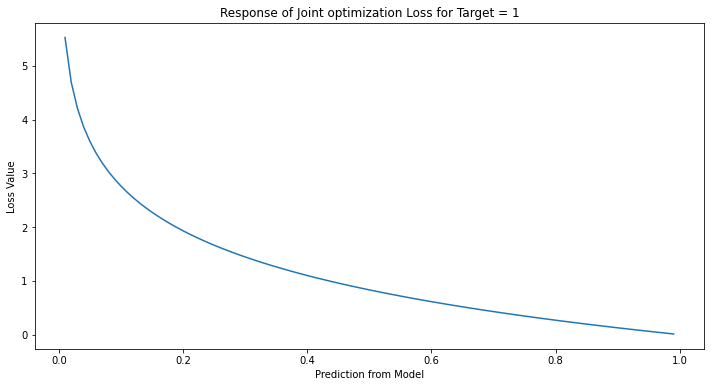

In [ ]:
inputs = [x/100 for x in range(0, 100, 1)]
outputs = []

for i in inputs:
    outputs.append(joint_optimization_loss(tf.convert_to_tensor([1.0]), tf.convert_to_tensor([i])).numpy())
    
plt.figure(figsize=(12,6))
plt.plot(inputs, outputs)
plt.title("Response of Joint optimization Loss for Target = 1")
plt.xlabel("Prediction from Model")
plt.ylabel("Loss Value")
plt.show()

**Bi-Tempered logistic loss**

Bi-Tempered logistic loss is a generalized softmax cross-entropy loss function with bounded loss value per sample and a heavy-tail softmax probability function.

https://ai.googleblog.com/2019/08/bi-tempered-logistic-loss-for-training.html

In [ ]:
import functools

def for_loop(num_iters, body, initial_args):
  """Runs a simple for-loop with given body and initial_args.
  Args:
    num_iters: Maximum number of iterations.
    body: Body of the for-loop.
    initial_args: Args to the body for the first iteration.
  Returns:
    Output of the final iteration.
  """
  for i in range(num_iters):
    if i == 0:
      outputs = body(*initial_args)
    else:
      outputs = body(*outputs)
  return outputs

def exp_t(u, t):
  """Compute exp_t for `u`."""

  def _internal_exp_t(u, t):
    return tf.nn.relu(1.0 + (1.0 - t) * u)**(1.0 / (1.0 - t))

  return tf.cond(
      tf.equal(t, 1.0), lambda: tf.exp(u),
      functools.partial(_internal_exp_t, u, t))

def log_t(u, t):
  """
  Compute log_t for `u`.
  
  https://github.com/google/bi-tempered-loss
  """

  def _internal_log_t(u, t):
    return (u**(1.0 - t) - 1.0) / (1.0 - t)

  return tf.cond(
      pred=tf.equal(t, 1.0), true_fn=lambda: tf.math.log(u),
      false_fn=functools.partial(_internal_log_t, u, t))

def compute_normalization(activations, t, num_iters=5):
  """Returns the normalization value for each example.
  Args:
    activations: A multi-dimensional tensor with last dimension `num_classes`.
    t: Temperature 2 (< 1.0 for finite support, > 1.0 for tail heaviness).
    num_iters: Number of iterations to run the method.
  Return: A tensor of same rank as activation with the last dimension being 1.
  """
  return tf.cond(
      pred=tf.less(t, 1.0),
      true_fn=functools.partial(compute_normalization_binary_search, activations, t,
                        num_iters),
      false_fn=functools.partial(compute_normalization_fixed_point, activations, t,
                        num_iters))

def compute_normalization_binary_search(activations, t, num_iters=10):
  """Returns the normalization value for each example (t < 1.0).
  Args:
    activations: A multi-dimensional tensor with last dimension `num_classes`.
    t: Temperature 2 (< 1.0 for finite support).
    num_iters: Number of iterations to run the method.
  Return: A tensor of same rank as activation with the last dimension being 1.
  """
  mu = tf.reduce_max(input_tensor=activations, axis=-1, keepdims=True)
  normalized_activations = activations - mu
  shape_activations = tf.shape(input=activations)
  effective_dim = tf.cast(
      tf.reduce_sum(
          input_tensor=tf.cast(
              tf.greater(normalized_activations, -1.0 / (1.0 - t)), tf.int32),
          axis=-1,
          keepdims=True), tf.float32)
  shape_partition = tf.concat([shape_activations[:-1], [1]], 0)
  lower = tf.zeros(shape_partition)
  upper = -log_t(1.0 / effective_dim, t) * tf.ones(shape_partition)

  def iter_body(i, lower, upper):
    logt_partition = (upper + lower)/2.0
    sum_probs = tf.reduce_sum(input_tensor=exp_t(
        normalized_activations - logt_partition, t), axis=-1, keepdims=True)
    update = tf.cast(tf.less(sum_probs, 1.0), tf.float32)
    lower = tf.reshape(lower * update + (1.0 - update) * logt_partition,
                       shape_partition)
    upper = tf.reshape(upper * (1.0 - update) + update * logt_partition,
                       shape_partition)
    return [i + 1, lower, upper]

  _, lower, upper = for_loop(num_iters, iter_body, [0, lower, upper])
  logt_partition = (upper + lower)/2.0
  return logt_partition + mu

def compute_normalization_fixed_point(activations, t, num_iters=5):
  """Returns the normalization value for each example (t > 1.0).
  Args:
    activations: A multi-dimensional tensor with last dimension `num_classes`.
    t: Temperature 2 (> 1.0 for tail heaviness).
    num_iters: Number of iterations to run the method.
  Return: A tensor of same rank as activation with the last dimension being 1.
  """

  mu = tf.reduce_max(input_tensor=activations, axis=-1, keepdims=True)
  normalized_activations_step_0 = activations - mu
  shape_normalized_activations = tf.shape(input=normalized_activations_step_0)

  def iter_body(i, normalized_activations):
    logt_partition = tf.reduce_sum(
        input_tensor=exp_t(normalized_activations, t), axis=-1, keepdims=True)
    normalized_activations_t = tf.reshape(
        normalized_activations_step_0 * tf.pow(logt_partition, 1.0 - t),
        shape_normalized_activations)
    return [i + 1, normalized_activations_t]

  _, normalized_activations_t = for_loop(num_iters, iter_body,
                                         [0, normalized_activations_step_0])
  logt_partition = tf.reduce_sum(
      input_tensor=exp_t(normalized_activations_t, t), axis=-1, keepdims=True)
  return -log_t(1.0 / logt_partition, t) + mu
    
def _internal_bi_tempered_logistic_loss(activations, labels, t1, t2):
    """
    
    https://github.com/google/bi-tempered-loss
    
    Computes the Bi-Tempered logistic loss.
        Args:
            activations: A multi-dimensional tensor with last dimension `num_classes`.
            labels: batch_size
            t1: Temperature 1 (< 1.0 for boundedness).
            t2: Temperature 2 (> 1.0 for tail heaviness).
        Returns:
            A loss tensor for robust loss.
    """
    if t2 == 1.0:
        normalization_constants = tf.math.log(
            tf.reduce_sum(input_tensor=tf.exp(activations), axis=-1, keepdims=True))
        if t1 == 1.0:
              return normalization_constants + tf.reduce_sum(
                  input_tensor=tf.multiply(labels, tf.math.log(labels + 1e-10) - activations), axis=-1)
        else:
            shifted_activations = tf.exp(activations - normalization_constants)
            one_minus_t1 = (1.0 - t1)
            one_minus_t2 = 1.0
    else:
        one_minus_t1 = (1.0 - t1)
        one_minus_t2 = (1.0 - t2)
        normalization_constants = compute_normalization(
            activations, t2, num_iters=5)
        shifted_activations = tf.nn.relu(1.0 + one_minus_t2 *
                                     (activations - normalization_constants))

    if t1 == 1.0:
        return tf.reduce_sum(
            input_tensor=tf.multiply(
                tf.math.log(labels + 1e-10) -
                tf.math.log(tf.pow(shifted_activations, 1.0 / one_minus_t2)), labels),
            axis=-1)
    else:
        beta = 1.0 + one_minus_t1
        logt_probs = (tf.pow(shifted_activations, one_minus_t1 / one_minus_t2) -
                      1.0) / one_minus_t1
        return tf.reduce_sum(
            input_tensor=tf.multiply(log_t(labels, t1) - logt_probs, labels) - 1.0 / beta *
            (tf.pow(labels, beta) -
             tf.pow(shifted_activations, beta / one_minus_t2)), axis=-1)

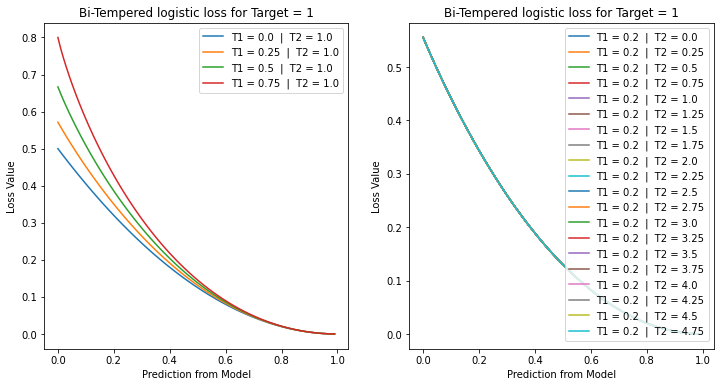

In [ ]:
inputs = [x/100 for x in range(0, 100, 1)]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

for t1 in [temp1/100 for temp1 in range(0, 100, 25)]:
    outputs = []
    for i in inputs:
        outputs.append(_internal_bi_tempered_logistic_loss(tf.convert_to_tensor([1.0]), tf.convert_to_tensor([i]), t1, 1.0).numpy())
    
    ax1.plot(inputs, outputs, label="T1 = " + str(t1) +"  |  T2 = 1.0")
    ax1.set_title("Bi-Tempered logistic loss for Target = 1")
    ax1.set_xlabel("Prediction from Model")
    ax1.set_ylabel("Loss Value")
    
for t2 in [temp2/100 for temp2 in range(0, 500, 25)]:
    outputs = []
    for i in inputs:
        outputs.append(_internal_bi_tempered_logistic_loss(tf.convert_to_tensor([1.0]), tf.convert_to_tensor([i]), 0.2, t2).numpy())
    
    ax2.plot(inputs, outputs, label="T1 = 0.2  |  T2 = " + str(t2))
    ax2.set_title("Bi-Tempered logistic loss for Target = 1")
    ax2.set_xlabel("Prediction from Model")
    ax2.set_ylabel("Loss Value")

ax1.legend()
ax2.legend()